# SV Phenotype Analysis using Information Gain

This notebook analyzes the structural variant (SV) phenotypes by combining data from sample and background populations. We'll use information gain analysis to identify significant features and patterns in the combined dataset.

## Import Required Libraries

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import entropy as scipy_entropy
import matplotlib.pyplot as plt
import seaborn as sns

def entropy(column):
    value, counts = np.unique(column, return_counts=True)
    probs = counts / len(column)
    return scipy_entropy(probs, base=2)

def information_gain(data, feature, target):
    original_entropy = entropy(data[target].values)
    total_rows = len(data)
    weighted_entropy = 0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        prob = len(subset) / total_rows
        weighted_entropy += prob * entropy(subset[target].values)
    return original_entropy - weighted_entropy

def conditional_entropy(data, feature, target):
    total = len(data)
    ce = 0.0
    for value in data[feature].unique():
        subset = data[data[feature] == value]
        prob = len(subset) / total
        ce += prob * entropy(subset[target].values)
    return ce

## Load and Combine Sample and Background Data

In [8]:
# Load sample and background phenotypes
sample_df = pd.read_csv('sample_sv_phenotypes.csv')
background_df = pd.read_csv('background_sv_phenotypes.csv')

# Combine the datasets
combined_df = pd.concat([sample_df, background_df], ignore_index=True)

print(f"Combined dataset shape: {combined_df.shape}")
print(f"\nPhenotype distribution:")
print(combined_df['phenotype'].value_counts())

Combined dataset shape: (3686, 59)

Phenotype distribution:
phenotype
Normal           3436
CLP               196
CL                 53
Hypertelorism       1
Name: count, dtype: int64


## Encode Categorical Columns

In [9]:
# Store original phenotype column
phenotype_col = combined_df['phenotype']

# Remove 'sample' and 'phenotype' columns before encoding
features_df = combined_df.drop(['sample', 'phenotype'], axis=1)

# Encode non-numeric categorical columns as integers
encoded_df = pd.DataFrame()
encodings = {}  # Store encoding mappings

for col in features_df.columns:
    if features_df[col].dtype == 'object':
        encoded_df[col], uniques = pd.factorize(features_df[col])
        encodings[col] = dict(enumerate(uniques))
    else:
        encoded_df[col] = features_df[col]

# Add back phenotype column for analysis
encoded_df['phenotype'] = pd.factorize(phenotype_col)[0]
encodings['phenotype'] = dict(enumerate(pd.unique(phenotype_col)))

print("Columns encoded:", len(encodings))
print("\nEncoding mappings:")
for col, mapping in encodings.items():
    print(f"\n{col}:", mapping)

Columns encoded: 1

Encoding mappings:

phenotype: {0: 'CLP', 1: 'Normal', 2: 'CL', 3: 'Hypertelorism'}


## Save Encoded DataFrame

In [10]:
# Save encoded DataFrame to a new CSV file
encoded_file = 'combined_sv_phenotypes_encoded.csv'
encoded_df.to_csv(encoded_file, index=False)
print(f"Encoded CSV saved as: {encoded_file}")

# Display first few rows of encoded data
print("\nFirst few rows of encoded data:")
encoded_df.head()

Encoded CSV saved as: combined_sv_phenotypes_encoded.csv

First few rows of encoded data:


,C_107117,C_109245,C_113972,C_121569,C_128215,C_135176,C_135462,C_148215,C_154706,C_154763,...,C_54086,C_64833,C_88109,C_90808,C_91851,C_9541,C_9550,C_97874,C_99036,phenotype
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Calculate Entropy and Information Gain

In [11]:
# Set target column (phenotype) and features
target_col = 'phenotype'
features = [col for col in encoded_df.columns if col != target_col]

# Calculate entropy of the target column
target_entropy = entropy(encoded_df[target_col].values)
print(f"Entropy of target column '{target_col}': {target_entropy:.4f}\n")

# Calculate information gain and conditional entropy for each feature
ig_results = []
for feature in features:
    ig = information_gain(encoded_df, feature, target_col)
    ce = conditional_entropy(encoded_df, feature, target_col)
    ig_results.append({
        'Feature': feature,
        'Score': ig,
        'Conditional Entropy': ce
    })
    print(f"Information gain for '{feature}': {ig:.4f}")

# Add target entropy as a reference
ig_results.append({
    'Feature': f"Entropy (Target {target_col})",
    'Score': target_entropy,
    'Conditional Entropy': float('nan')  # Not applicable
})

Entropy of target column 'phenotype': 0.4108

Information gain for 'C_107117': 0.0000
Information gain for 'C_109245': 0.0011
Information gain for 'C_113972': 0.0011
Information gain for 'C_121569': 0.0000
Information gain for 'C_128215': 0.0006
Information gain for 'C_135176': 0.0000
Information gain for 'C_135462': 0.0006
Information gain for 'C_148215': 0.0006
Information gain for 'C_154706': 0.0000
Information gain for 'C_154763': 0.0000
Information gain for 'C_154766': 0.0002
Information gain for 'C_154770': 0.0000
Information gain for 'C_155393': 0.0000
Information gain for 'C_155411': 0.0000
Information gain for 'C_16066': 0.0011
Information gain for 'C_162773': 0.0000
Information gain for 'C_162775': 0.0000
Information gain for 'C_162777': 0.0000
Information gain for 'C_163987': 0.0011
Information gain for 'C_164798': 0.0011
Information gain for 'C_167106': 0.0006
Information gain for 'C_167108': 0.0011
Information gain for 'C_171588': 0.0006
Information gain for 'C_175033': 0.

## Visualize Information Gain and Conditional Entropy

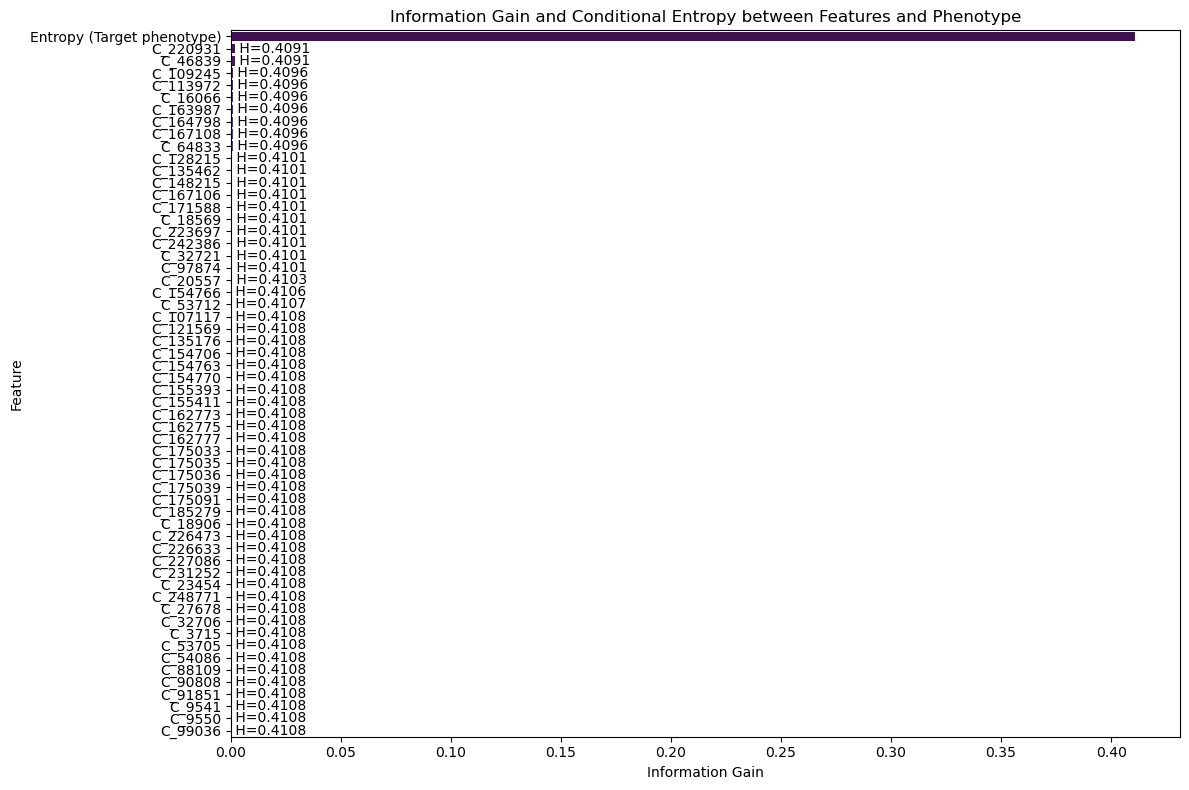


Top 10 Most Informative Features:
     Feature     Score  Conditional Entropy
32  C_220931  0.001664             0.409094
45   C_46839  0.001664             0.409094
1   C_109245  0.001149             0.409608
2   C_113972  0.001149             0.409608
14   C_16066  0.001149             0.409608
18  C_163987  0.001149             0.409608
19  C_164798  0.001149             0.409608
21  C_167108  0.001149             0.409608
49   C_64833  0.001149             0.409609
4   C_128215  0.000634             0.410124


In [12]:
# Create DataFrame from results
ig_df = pd.DataFrame(ig_results)

# Sort so "Entropy (Target)" is first, then the rest by descending score
ig_df['Is_Entropy'] = ig_df['Feature'].str.startswith('Entropy')
ig_df = ig_df.sort_values(['Is_Entropy', 'Score'], ascending=[False, False]).drop('Is_Entropy', axis=1)

# Create visualization
plt.figure(figsize=(12, 8))
ax = sns.barplot(
    x='Score', 
    y='Feature', 
    data=ig_df, 
    hue='Feature', 
    palette='viridis', 
    legend=False
)

# Annotate each bar with conditional entropy (if not the target entropy row)
for i, (feature, ce) in enumerate(zip(ig_df['Feature'], ig_df['Conditional Entropy'])):
    if not feature.startswith('Entropy'):
        ax.text(
            x=ig_df['Score'].iloc[i],
            y=i,
            s=f" H={ce:.4f}",
            va='center',
            ha='left',
            color='black'
        )

plt.title('Information Gain and Conditional Entropy between Features and Phenotype')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Display top 10 most informative features
print("\nTop 10 Most Informative Features:")
top_features = ig_df[~ig_df['Feature'].str.startswith('Entropy')].head(10)
print(top_features[['Feature', 'Score', 'Conditional Entropy']])